# CNN 練習


## 匯入所需套件

In [1]:
# import package
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [ ]:
#測試是否有使用到GPU

# Apple M-series SoC
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

# NVIDIA GPU
print(torch.cuda.is_available())
print(torch.backends.cuda.is_built())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 使用 NVIDIA GPU
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # 使用 Apple M-series SoC

## 一、Cifar10 資料讀入及前處理

### 1. 資料預處理，包含rescale, 資料擴增

In [ ]:
# Cifar-10 data
transform = transforms.Compose([transforms.ToTensor()])

### 2. 讀取cifar10 資料集進來

In [ ]:
# Data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [ ]:
X_train = [] # 訓練集圖片
y_train = [] # 訓練集標籤
X_test = []  # 測試集圖片
y_test = []  # 測試集標籤

for images, labels in trainset:
    X_train.append(np.array(images))
    y_train.append(np.array(labels))

for images, labels in testset:
    X_test.append(np.array(images))
    y_test.append(np.array(labels))

In [ ]:
X_train = np.array(X_train)
print(X_train.shape)

### <span style="color:red">下圖是Cifar10的10個分類</span>
![Imgur](https://i.imgur.com/44srTgL.png)

### 3. 建立一個標籤字典

In [ ]:
label_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
num_classes = len(label_dict)

### 4. 查看訓練集資料圖片

In [ ]:
# 查看第一張圖片及標籤
Img = X_train[0]
plt.imshow(np.transpose(Img,(1,2,0)))  # 轉回正常格式 從CHW (Channel, Height, Width)轉回HWC
plt.title(label_dict[int(y_train[0])])

### 5. 隨機查看訓練集資料圖片(最多25張)

In [ ]:
#隨機查看圖片
import random
def ShowImage(images,labels,total=10):  # 圖片，標籤，預測標籤，總共顯示張數
    plt.gcf().set_size_inches(18, 20)
    if total >= 25:
        total = 25

    for i in range(0, total):
        num = random.randint(0,len(labels)-1)
        img_show = plt.subplot(5, 5, i+1)
        Img = images[num]
        img_show.imshow(np.transpose(Img,(1,2,0)))
        title = "Label = " + str(label_dict[int(labels[num])])
        plt.title(title)
    plt.show()

ShowImage(X_train,y_train,total=25)

## 二、資料預處理

### 1. 將訓練集與測試集轉換為data generator

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
dataiter = iter(trainLoader) #迭代器
images,labels = next(dataiter)

In [ ]:
print(images.shape) #(batch, channel, Height, Width)
print(labels.shape)

## 三、設計模型架構

### 1. CNN model Structure

In [ ]:
# Model structure
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1)

        self.pool = nn.MaxPool2d(2, 2)
        self.act = nn.ReLU()

        self.fc = nn.Sequential(nn.Linear(in_features = 64*8*8, out_features = 128),  #512 * 7 * 7不能改變
                                nn.ReLU(True),
                                nn.Linear(in_features = 128, out_features = num_classes),)

    def forward(self, x):
        x = self.act(self.conv1(x)) # 32
        x = self.pool(self.act(self.conv2(x))) # 16
        x = self.act(self.conv3(x)) # 16
        x = self.pool(self.act(self.conv4(x))) # 8
        x = x.view(-1, 64*8*8)
        x = self.fc(x)

        return x

cnn_model = CNN().to(device)
print(cnn_model)
#summary(cnn_model, input_size=(3, 32, 32))

## 2. DNN model Structure

In [ ]:
# Model structure
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(in_features = 3*32*32, out_features = 512)
        self.fc2 = nn.Linear(in_features = 512, out_features = 256)
        self.fc3 = nn.Linear(in_features = 256, out_features = 128)
        self.output = nn.Linear(in_features = 128, out_features = 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        output = self.output(x)

        return output

dnn_model = DNN().to(device)
print(dnn_model)
#summary(cnn_model, input_size=(3, 32, 32))

## 四、開始訓練模型

### 1. 編譯CNN模型

In [ ]:
# 選用Adam為optimizer
# Parameters
# pytorch的CrossEntropyLoss在計算時，會以softmax的輸出作為最後的結果

criterion = nn.CrossEntropyLoss()
lr = 0.001
epochs = 10
#optimizer_cnn = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)



### 2. CNN model Train

In [ ]:
# 訓練過程
# len(trainLoader) : 訓練集總共的資料量 / batch
# len(trainLoader.dataset) : 訓練集總共的資料量

cnn_loss_history = []
cnn_acc_history = []

cnn_valloss_history = []
cnn_valacc_history = []

for epoch in range(epochs):
    # 訓練階段
    running_loss = 0.0
    accuracy = 0.0
    total = 0.0
    for times, data_train in enumerate(trainLoader, 0):
        # batch data input
        inputs, labels = data_train
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer_cnn.zero_grad()

        # model Feedforward
        output_train = cnn_model(inputs)

        # Feed forward loss result
        loss = criterion(output_train, labels)

        # backward update
        loss.backward()

        # optimize
        optimizer_cnn.step()

        # Compute loss
        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(output_train.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()

        if times+1 == len(trainLoader):
            print('[%d/%d, %d/%d] loss: %.3f, acc: %.3f,' % (epoch+1,
                                                             epochs,
                                                             times+1,
                                                             len(trainLoader),
                                                             running_loss/len(trainLoader),
                                                             accuracy / total),end = " ")
            cnn_loss_history.append(running_loss/len(trainLoader))
            cnn_acc_history.append(accuracy / total)
            running_loss = 0.0

    # 測試階段
    cnn_model.eval()
    test_loss = 0.0
    accuracy = 0.0
    total = 0.0
    with torch.no_grad(): # disable gradient calculation for efficiency
        for times, data_test in enumerate(testLoader, 0):
            # batch data input
            inputs, labels = data_test
            inputs, labels = inputs.to(device), labels.to(device)

            # model predict
            output_test = cnn_model(inputs)

            # Compute loss
            loss_t = criterion(output_test, labels)
            test_loss += loss_t.item()

            # Compute accuracy
            _, predicted = torch.max(output_test.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

            if times+1 == len(testLoader):
                print('test_loss: %.3f, test_acc: %.3f' % (test_loss / len(testLoader),
                                                           accuracy / total))

                cnn_valloss_history.append(test_loss / len(testLoader))
                cnn_valacc_history.append(accuracy / total)
                test_loss = 0.0

print('Finished Training')

In [ ]:
torch.save(cnn_model, 'cnn_model.pth')

### 3. 編譯DNN模型

In [ ]:
# 選用Adam為optimizer
# Parameters
# pytorch的CrossEntropyLoss在計算時，會以softmax的輸出作為最後的結果

criterion = nn.CrossEntropyLoss()
lr = 0.001
epochs = 10
optimizer_dnn = optim.Adam(dnn_model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)



### 4. DNN model Train

In [ ]:
# 訓練過程
# len(trainLoader) : 訓練集總共的資料量 / batch
# len(trainLoader.dataset) : 訓練集總共的資料量

dnn_loss_history = []
dnn_acc_history = []

dnn_valloss_history = []
dnn_valacc_history = []

for epoch in range(epochs):
    # 訓練階段
    running_loss = 0.0
    accuracy = 0.0
    total = 0.0
    for times, data_train in enumerate(trainLoader, 0):
        # batch data input
        inputs, labels = data_train
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer_dnn.zero_grad()

        # model Feedforward
        output_train = dnn_model(inputs)

        # Feed forward loss result
        loss = criterion(output_train, labels)

        # backward update
        loss.backward()

        # optimize
        optimizer_dnn.step()

        # Compute loss
        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(output_train.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()

        if times+1 == len(trainLoader):
            print('[%d/%d, %d/%d] loss: %.3f, acc: %.3f,' % (epoch+1,
                                                             epochs,
                                                             times+1,
                                                             len(trainLoader),
                                                             running_loss/len(trainLoader),
                                                             accuracy / total),end = " ")
            dnn_loss_history.append(running_loss/len(trainLoader))
            dnn_acc_history.append(accuracy / total)
            running_loss = 0.0

    # 測試階段
    dnn_model.eval()
    test_loss = 0.0
    accuracy = 0.0
    total = 0.0
    with torch.no_grad(): # disable gradient calculation for efficiency
        for times, data_test in enumerate(testLoader, 0):
            # batch data input
            inputs, labels = data_test
            inputs, labels = inputs.to(device), labels.to(device)

            # model predict
            output_test = dnn_model(inputs)

            # Compute loss
            loss_t = criterion(output_test, labels)
            test_loss += loss_t.item()

            # Compute accuracy
            _, predicted = torch.max(output_test.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

            if times+1 == len(testLoader):
                print('test_loss: %.3f, test_acc: %.3f' % (test_loss / len(testLoader),
                                                           accuracy / total))

                dnn_valloss_history.append(test_loss / len(testLoader))
                dnn_valacc_history.append(accuracy / total)
                test_loss = 0.0

print('Finished Training')

## 五、訓練結果視覺化

In [ ]:
def Show_Train_flow(train_cnnmodel, test_cnnmodel, Show = 'loss', Title='Training accuracy comparision'):
    plt.plot(train_cnnmodel)
    plt.plot(test_cnnmodel)
    plt.title(Title)
    plt.ylabel(Show)
    plt.xlabel('Epoch')
    plt.legend(['train','test'])
    plt.show()

Show_Train_flow(cnn_loss_history, cnn_valloss_history, Show = 'loss', Title='cnn loss comparision')
Show_Train_flow(cnn_acc_history, cnn_valacc_history, Show = 'acc', Title='cnn acc comparision')
Show_Train_flow(dnn_loss_history, dnn_valloss_history, Show = 'loss', Title='dnn loss comparision')
Show_Train_flow(dnn_acc_history, dnn_valacc_history, Show = 'acc', Title='dnn acc comparision')

## 六、測試集預測，查看測試集的表現

### 1.單一筆測試集圖片的預測

In [ ]:
cnn_model = torch.load('cnn_model.pth')

In [ ]:
softmax_output = nn.Softmax(dim=1)

In [ ]:
ImgTest = np.expand_dims(X_test[0], axis=0) # (3,32,32) -> (1,3,32,32)
ImgTest = torch.tensor(ImgTest)             # 將圖片轉換成torch tensor(才能丟入模型進行預測)
ImgTest = ImgTest.to(device)                # to gpu mode
Result = cnn_model(ImgTest)                 # Predict images
sm_Result = softmax_output(Result)          # softmax output

In [ ]:
sm_Result = sm_Result.data.cpu().numpy()    # 將結果轉換成numpy格式(因為預測是用gpu，所以這裡要轉換成cpu格式才能轉numpy array)

In [ ]:
CnnargmaxResult = label_dict[sm_Result[0].argmax()]
RealResult = label_dict[int(y_test[0])]

plt.imshow(np.transpose(X_test[0],(1,2,0))) #轉回正常格式 從chw轉回hwc
plt.title("Predict label : %s\n True label : %s"%(CnnargmaxResult, RealResult))

### 2. 全部測試集的預測

In [ ]:
predict_output = []
for i in range(len(X_test)):
    ImgTest = np.expand_dims(X_test[i], axis=0) # (3,32,32) -> (1,3,32,32)
    ImgTest = torch.tensor(ImgTest)             # 將圖片轉換成torch tensor(才能丟入模型進行預測)
    ImgTest = ImgTest.to(device)                # to gpu mode
    Result = cnn_model(ImgTest)                 # Predict images
    sm_Result = softmax_output(Result)          # softmax output

    sm_Result = sm_Result.data.cpu().numpy()
    predict_output.append(sm_Result[0].argmax())

In [ ]:
y_predict = [] #所有預測的結果
y_TrueLabel=[] #所有真實標籤的結果

#(1,5,9,6)
#(dog, cat)
for i in range(len(X_test)):
    y_predict.append(label_dict[predict_output[i]])#將結果儲存起來
    y_TrueLabel.append(label_dict[int(y_test[i])])#將真實標籤從字典找出相對應的標籤後儲存起來

y_TrueLabel = np.asarray(y_TrueLabel)
y_predict = np.asarray(y_predict)

In [ ]:
print(y_TrueLabel)
print(y_predict)

### Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_TrueLabel, y_predict, digits = 3))

In [ ]:
import pandas as pd

display(pd.crosstab(y_TrueLabel, y_predict, rownames=["True"], colnames=["Predict"]))

# 課堂練習
隨機顯示出測試集的10-25張圖片，並且顯示出CNN預測出來的結果以及原本正確的標籤
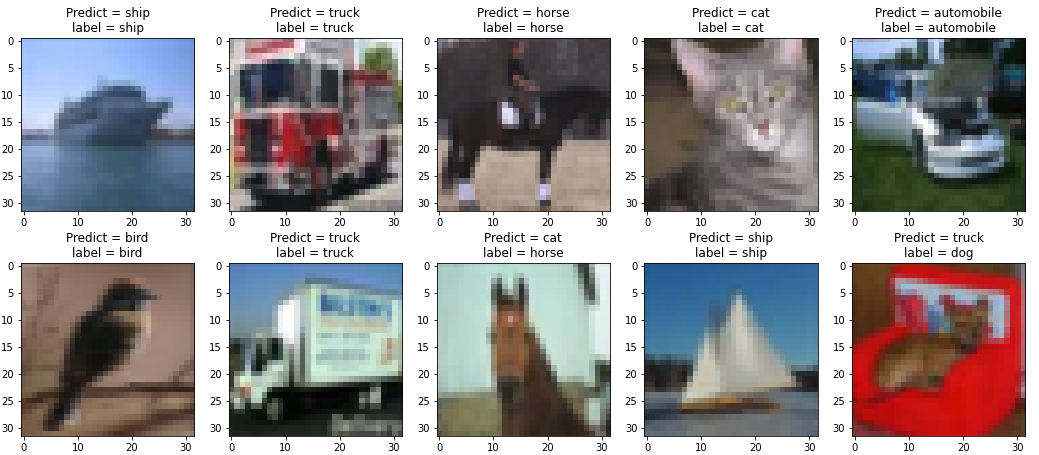

In [ ]:
#隨機查看圖片
import random
def ShowImage(images,labels,predictions,total=10): #圖片，標籤，預測標籤，總共顯示張數
    plt.gcf().set_size_inches(18, 20)


ShowImage(X_test,y_TrueLabel,y_predict,total=25)